1) Desarrollar 1 de los siguientes 
5. Modelo que pueda clasificar diferentes especies de granos de trigo a partir de imágenes fotográficas.

Lo modelos deben lograr por lo menos un 80% de precisión con datos de prueba.

Dataset: https://drive.google.com/drive/folders/1UQTKiunyz_Ib-xb71wkDUcW18vowfsg_?usp=sharing

Repositorio: https://github.com/erwin971030/SIS421/tree/master/Examen_invierno

In [1]:
import os
import torch
import random
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from PIL import Image
from skimage import io

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path_train = '/content/drive/MyDrive/2022 1/IA2/Examen_invierno/dataset/dataset_trigo/train/'
path_test = '/content/drive/MyDrive/2022 1/IA2/Examen_invierno/dataset/dataset_trigo/test/'
directorios_train = os.listdir(path_train)
directorios_test = os.listdir(path_test)
directorios_test , directorios_train

(['cuscus', 'trigo-duro-con-almidon', 'grano-duro-vitreo'],
 ['grano-duro-vitreo', 'trigo-duro-con-almidon', 'cuscus'])

In [3]:
labels_def = {'grano-duro-vitreo':0, 'trigo-duro-con-almidon':1, 'cuscus':2}

In [4]:
def loadImages(path, directorio):
    labels_ = []
    images_ = []
    for d in directorio:
        imagenes = os.listdir(path + d)
        for i in imagenes:
            imgPath2 = path + d + '/' + i
            images_.append(imgPath2)
            labels_.append(labels_def[d])
    return images_, labels_

def getText(label):
    for key in labels_def:
      if labels_def[key] == label:
        return key

In [5]:
imgs , labels = loadImages(path_train,directorios_train)
imgs_test , labels_test = loadImages(path_test,directorios_test)

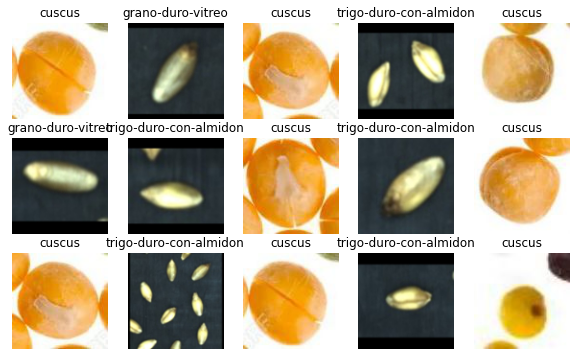

In [6]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(getText(labels[ix]))
plt.show()

In [7]:
train_imgs = imgs
test_imgs = imgs_test
train_labels = labels
test_labels = labels_test

len(train_imgs), len(test_imgs)

(585, 16)

In [8]:
class Dataset(torch.utils.data.Dataset):
    # constructor
    def __init__(self, X, Y):
        self.X = X #torch.from_numpy(X).float().cuda()
        self.Y = Y #torch.from_numpy(Y).long().cuda()
    # devolvemos el número de datos en el dataset
    def __len__(self):
        return len(self.X)
    # devolvemos el elemento `ix` del dataset
    def __getitem__(self, ix):
        img1 = Image.open(self.X[ix])
        new_img = img1.resize((60,60))
        #normalizamos la imagen 
        npImage = np.array(new_img)
        #return self.X[ix], self.Y[ix]
        #img = self.trans(image=img)["image"]
        # las redes convolucionales la primera dimension que espera 
        # son el numero de canales  
        return torch.from_numpy(npImage / 255.).float().permute(2,0,1), torch.tensor(self.Y[ix])

In [9]:
dataset = {
    'train': Dataset(train_imgs, train_labels), 
    'test': Dataset(test_imgs, test_labels)
}
len(dataset['train']), len(dataset['test']),

(585, 16)

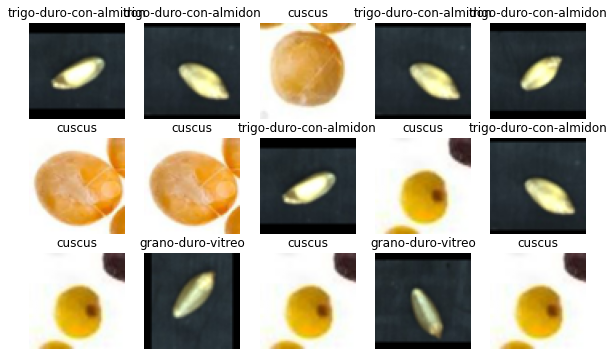

In [10]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['test'])-1)
    img, lab = dataset['test'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(getText(lab))
    #ax.set_title(classes[lab])
plt.show()

In [11]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=65, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=32, shuffle=True)
}

x_train, y_train = next(iter(dataloader['train']))

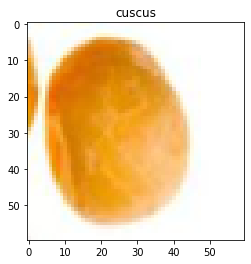

In [12]:
rand = random.randint(0, len(x_train))
img_perm=x_train[rand].permute(1, 2,0)
plt.imshow(img_perm)
plt.title(getText(y_train[rand]))
plt.show()

In [13]:
densenet = torchvision.models.densenet201()
densenet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [14]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=3, pretrained=False, freeze=False):
    super().__init__()
    # descargamos densenet201
    densenet = torchvision.models.densenet201(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.densenet = torch.nn.Sequential(*list(densenet.children())[:-1])
    #print(self.densenet)
    # Freeze congelar la red pone a false todos los parametros del modelo
    if freeze:
      for param in self.densenet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    # 1920 es lo que nos da densenet
    self.fc = torch.nn.Linear(1920, 3)
    print(self.fc)

  # Funcion que aplicara las capas de densenet
  def forward(self, x):
    x = self.densenet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    
    return x

  # pone a true los parametros del modelo 
  def unfreeze(self):
    for param in self.densenet.parameters():
        param.requires_grad=True

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
#torch.cuda.empty_cache()
model = Model()
outputs = model(torch.randn(64, 3, 60, 60)) 
outputs.shape
# probando el modelo nos tiene que dar 3 predicciones por batch 

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Linear(in_features=1920, out_features=3, bias=True)


torch.Size([64, 3])

In [17]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=10, lr=1e-4):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [18]:
# enteneamiento del modelo desde 0 sin usar los pesos preentrenados 
model_1 = Model()
fit(model, dataloader, epochs=6)

Linear(in_features=1920, out_features=3, bias=True)


val_loss 1.09920 val_acc 0.43750: 100%|██████████| 1/1 [00:05<00:00,  5.24s/it]


Epoch 1/6 loss 1.14179 val_loss 1.09920 acc 0.38120 val_acc 0.43750


val_loss 1.13812 val_acc 0.37500: 100%|██████████| 1/1 [00:00<00:00, 13.88it/s]


Epoch 2/6 loss 1.04403 val_loss 1.13812 acc 0.47521 val_acc 0.37500


val_loss 1.02417 val_acc 0.43750: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


Epoch 3/6 loss 0.95239 val_loss 1.02417 acc 0.54359 val_acc 0.43750


val_loss 0.88746 val_acc 0.68750: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


Epoch 4/6 loss 0.87054 val_loss 0.88746 acc 0.64615 val_acc 0.68750


val_loss 0.83935 val_acc 0.68750: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


Epoch 5/6 loss 0.83799 val_loss 0.83935 acc 0.66496 val_acc 0.68750


val_loss 0.72603 val_acc 0.81250: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]

Epoch 6/6 loss 0.81245 val_loss 0.72603 acc 0.66325 val_acc 0.81250


In [19]:
# entrenamiento de la ultima capa 
model_tl = Model(pretrained=True, freeze=True)
fit(model, dataloader)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

Linear(in_features=1920, out_features=3, bias=True)


val_loss 0.66075 val_acc 0.81250: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


Epoch 1/10 loss 0.75401 val_loss 0.66075 acc 0.70085 val_acc 0.81250


val_loss 0.58051 val_acc 0.81250: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


Epoch 2/10 loss 0.69995 val_loss 0.58051 acc 0.75214 val_acc 0.81250


val_loss 0.53120 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


Epoch 3/10 loss 0.69400 val_loss 0.53120 acc 0.75726 val_acc 0.87500


val_loss 0.52089 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


Epoch 4/10 loss 0.67290 val_loss 0.52089 acc 0.74701 val_acc 0.87500


val_loss 0.49551 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]


Epoch 5/10 loss 0.63766 val_loss 0.49551 acc 0.75556 val_acc 0.87500


val_loss 0.49171 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


Epoch 6/10 loss 0.63112 val_loss 0.49171 acc 0.76581 val_acc 0.87500


val_loss 0.48429 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


Epoch 7/10 loss 0.62077 val_loss 0.48429 acc 0.76923 val_acc 0.87500


val_loss 0.45402 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


Epoch 8/10 loss 0.58851 val_loss 0.45402 acc 0.79658 val_acc 0.87500


val_loss 0.45181 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


Epoch 9/10 loss 0.55871 val_loss 0.45181 acc 0.81538 val_acc 0.87500


val_loss 0.43535 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]

Epoch 10/10 loss 0.56473 val_loss 0.43535 acc 0.81538 val_acc 0.87500


In [20]:
# entrenamiento del modelo completo
model_ft = Model(pretrained=True, freeze=False)
fit(model, dataloader)

Linear(in_features=1920, out_features=3, bias=True)


val_loss 0.42606 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


Epoch 1/10 loss 0.54585 val_loss 0.42606 acc 0.80000 val_acc 0.87500


val_loss 0.41732 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


Epoch 2/10 loss 0.54334 val_loss 0.41732 acc 0.81368 val_acc 0.87500


val_loss 0.40068 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


Epoch 3/10 loss 0.53023 val_loss 0.40068 acc 0.80000 val_acc 0.87500


val_loss 0.37916 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


Epoch 4/10 loss 0.53369 val_loss 0.37916 acc 0.80513 val_acc 0.87500


val_loss 0.37838 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


Epoch 5/10 loss 0.49707 val_loss 0.37838 acc 0.83248 val_acc 0.87500


val_loss 0.38534 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


Epoch 6/10 loss 0.50746 val_loss 0.38534 acc 0.83077 val_acc 0.87500


val_loss 0.37131 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


Epoch 7/10 loss 0.47531 val_loss 0.37131 acc 0.85812 val_acc 0.87500


val_loss 0.35922 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


Epoch 8/10 loss 0.47135 val_loss 0.35922 acc 0.85299 val_acc 0.87500


val_loss 0.36070 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 13.40it/s]


Epoch 9/10 loss 0.46352 val_loss 0.36070 acc 0.84615 val_acc 0.87500


val_loss 0.34618 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]

Epoch 10/10 loss 0.46594 val_loss 0.34618 acc 0.85812 val_acc 0.87500


In [21]:
# descargamos los pesos pero congelamos la red  
model_modif = Model(pretrained=True, freeze=True)
# entrenamos durante unas cuantas epocs 
fit(model, dataloader)
# entrenamiento de todo 
model.unfreeze()
fit(model, dataloader, lr=1e-5)

Linear(in_features=1920, out_features=3, bias=True)


val_loss 0.34502 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


Epoch 1/10 loss 0.45691 val_loss 0.34502 acc 0.85128 val_acc 0.87500


val_loss 0.33676 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


Epoch 2/10 loss 0.47396 val_loss 0.33676 acc 0.82906 val_acc 0.87500


val_loss 0.34145 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


Epoch 3/10 loss 0.45165 val_loss 0.34145 acc 0.85470 val_acc 0.87500


val_loss 0.33412 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Epoch 4/10 loss 0.45771 val_loss 0.33412 acc 0.84615 val_acc 0.87500


val_loss 0.32774 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


Epoch 5/10 loss 0.43017 val_loss 0.32774 acc 0.87521 val_acc 0.87500


val_loss 0.32635 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


Epoch 6/10 loss 0.43485 val_loss 0.32635 acc 0.88034 val_acc 0.87500


val_loss 0.32095 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 13.30it/s]


Epoch 7/10 loss 0.41318 val_loss 0.32095 acc 0.88718 val_acc 0.87500


val_loss 0.31393 val_acc 0.93750: 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]


Epoch 8/10 loss 0.40284 val_loss 0.31393 acc 0.87521 val_acc 0.93750


val_loss 0.30715 val_acc 0.93750: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


Epoch 9/10 loss 0.40421 val_loss 0.30715 acc 0.88034 val_acc 0.93750


val_loss 0.30582 val_acc 0.93750: 100%|██████████| 1/1 [00:00<00:00, 12.51it/s]


Epoch 10/10 loss 0.39903 val_loss 0.30582 acc 0.88547 val_acc 0.93750


val_loss 0.30412 val_acc 0.93750: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


Epoch 1/10 loss 0.38860 val_loss 0.30412 acc 0.88718 val_acc 0.93750


val_loss 0.30740 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


Epoch 2/10 loss 0.38733 val_loss 0.30740 acc 0.90598 val_acc 0.87500


val_loss 0.30776 val_acc 0.93750: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


Epoch 3/10 loss 0.39430 val_loss 0.30776 acc 0.87350 val_acc 0.93750


val_loss 0.30152 val_acc 0.93750: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


Epoch 4/10 loss 0.41056 val_loss 0.30152 acc 0.88034 val_acc 0.93750


val_loss 0.29970 val_acc 0.93750: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s]


Epoch 5/10 loss 0.42405 val_loss 0.29970 acc 0.86667 val_acc 0.93750


val_loss 0.29684 val_acc 0.93750: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


Epoch 6/10 loss 0.40303 val_loss 0.29684 acc 0.87521 val_acc 0.93750


val_loss 0.30003 val_acc 0.93750: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


Epoch 7/10 loss 0.39614 val_loss 0.30003 acc 0.88547 val_acc 0.93750


val_loss 0.29662 val_acc 0.93750: 100%|██████████| 1/1 [00:00<00:00, 13.60it/s]


Epoch 8/10 loss 0.40460 val_loss 0.29662 acc 0.86496 val_acc 0.93750


val_loss 0.29379 val_acc 0.93750: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


Epoch 9/10 loss 0.40032 val_loss 0.29379 acc 0.88205 val_acc 0.93750


val_loss 0.29614 val_acc 0.93750: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]

Epoch 10/10 loss 0.39324 val_loss 0.29614 acc 0.88205 val_acc 0.93750


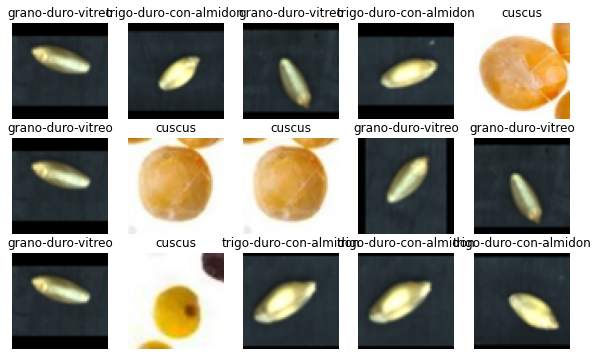

In [22]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['test'])-1)
    img, lab = dataset['test'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(getText(lab))

In [23]:
torch.save(model_ft.state_dict(), 'saved_weights_ft.pt')
path = 'saved_weights_ft.pt'

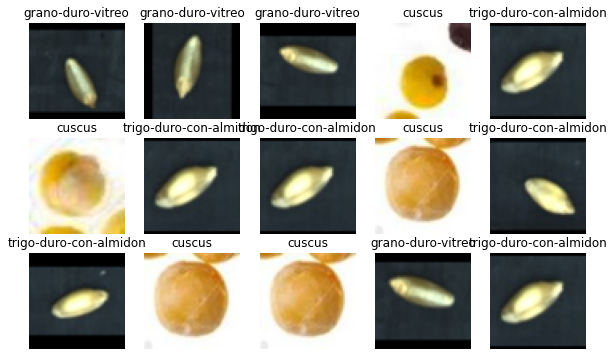

In [24]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['test'])-1)
    img, lab = dataset['test'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(getText(lab))

In [25]:
image_al = Image.open('/content/drive/MyDrive/2022 1/IA2/Examen_invierno/prueba/imagen_1.jpg')
new_img_alm = image_al.resize((60,60))
npImage_1 = np.array(new_img_alm)

image_vit = Image.open('/content/drive/MyDrive/2022 1/IA2/Examen_invierno/prueba/imagen_2.jpg')
new_img_vit = image_vit.resize((60,60))
npImage_2 = np.array(new_img_alm)

imagen_01 =  torch.from_numpy(npImage_1 / 255.).float().permute(2,0,1)
imagen_02 =  torch.from_numpy(npImage_2 / 255.).float().permute(2,0,1)

In [26]:
model_ft.eval()
with torch.no_grad():
    output1 = model(imagen_02.unsqueeze(0).to(device))[0]
    pred_1 = torch.argmax(output1, axis=0)
pred_1

tensor(1, device='cuda:0')

In [27]:
model_ft.eval()
with torch.no_grad():
    output2 = model(imagen_02.unsqueeze(0).to(device))[0]
    pred_2 = torch.argmax(output2, axis=0)
pred_2

tensor(1, device='cuda:0')

In [28]:
image_c = Image.open('/content/drive/MyDrive/2022 1/IA2/Examen_invierno/prueba/imagen_av_3.jpg')
new_img_cm = image_c.resize((60,60))
npImage_3 = np.array(new_img_cm)
imagen_03 =  torch.from_numpy(npImage_3 / 255.).float().permute(2,0,1)

In [29]:
model_ft.eval()
with torch.no_grad():
    output3 = model(imagen_03.unsqueeze(0).to(device))[0]
    pred_3 = torch.argmax(output3, axis=0)
pred_3

tensor(1, device='cuda:0')

In [33]:
x = torch.rand(64, 3, 60, 60)
y = model.cpu()(x)

# exportamos el modelo
torch.onnx.export(model,                     # el modelo
                  x,                         # un ejemplo del input
                  "model.onnx",              # el nombre del archivo para guardar el modelo
                  export_params=True,        # guardar los pesos de la red
                  opset_version=10,          # versión de ONNX
                  do_constant_folding=True,  # optimizaciones
                  input_names = ['input'],   # nombre de los inputs
                  output_names = ['output'], # nombre de los outputs
                  dynamic_axes={'input' : {0 : 'batch_size'},    # ejes con longitud variable (para poder usar diferentes tamaños de batch)
                                'output' : {0 : 'batch_size'}})

In [34]:
!pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 25.5 MB/s 
     |████████████████████████████████| 46 kB 4.3 MB/s 
     |████████████████████████████████| 86 kB 7.1 MB/s 


In [35]:
import onnxruntime

def onnx_evaluate(model, dataloader): 
    # cargarmos el modelo
    ort_session = onnxruntime.InferenceSession(model)
    bar = tqdm(dataloader['test'])
    acc = []
    with torch.no_grad():
        for batch in bar:
            X, y = batch
            X, y = X.numpy(), y.numpy()
            # generamos los inputs
            ort_inputs = {ort_session.get_inputs()[0].name: X}
            # extraemos los outputs
            ort_outs = ort_session.run(None, ort_inputs)[0]
            acc.append((y == np.argmax(ort_outs, axis=1)).mean())
            bar.set_description(f"acc {np.mean(acc):.5f}")

In [36]:
onnx_evaluate("/content/model.onnx", dataloader)

acc 0.93750: 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]
